In [9]:
import logging
import os
import matplotlib as mpl
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from scipy.stats import reciprocal
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import LinearRegression

from qs_code.utils import rescale_window_split_dataframe, plot_predictions, plot_linear_model_coeffs, WEIGHT_COL_INDEX

mpl.rcParams['figure.figsize'] = (12, 8)
mpl.rcParams['axes.grid'] = False

# Silence tensorflow retracing warnings
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"  # FATAL
logging.getLogger("tensorflow").setLevel(logging.FATAL)

FILEPATH_FCNN = "saved_models//fcnn_model.h5"
FILEPATH_CNN = "saved_models//cnn_model.h5"
FILEPATH_RNN = "saved_models//rnn_model.h5"
FILEPATH_FCNN_REDUCED = "saved_models//fcnn_model_reduced.h5"
FILEPATH_CNN_REDUCED  = "saved_models//cnn_model_reduced.h5"
FILEPATH_RNN_REDUCED  = "saved_models//rnn_model_reduced.h5"
FILEPATH_FULL_DATASET = "data//dataset_full.csv"
FILEPATH_REDUCED_DATASET = "data//dataset_reduced.csv"
PLOT_BOUNDS = (0, 42)

df = pd.read_csv(FILEPATH_FULL_DATASET)
df_reduced = pd.read_csv(FILEPATH_REDUCED_DATASET)

## Model Comparison - All Features

Below I compare the success of the FCNN/CNN/RNN models on both the full and reduced feature datasets. To estimate how well the models are doing, I compare them to a baseline model which predicts the next day's weight to be the current day's weight. This is a common baseline model for time series. I also fit a simple linear regression model to the data as an additional point of comparison, to see if the more complex models are able to capture and leverage non-linear information in the data.

In [10]:
score_dict = {}
X_train, y_train, _, _, X_test, y_test, nan_idxs_test = rescale_window_split_dataframe(df)

# Baseline metric: guess previous day's weight as the next day's weight. 
score_dict["Baseline MAE"] = mean_absolute_error(X_test[:, 0, WEIGHT_COL_INDEX], y_test)

# Linear model
model_lin = LinearRegression().fit(np.squeeze(X_train), np.squeeze(y_train))
y_lin = model_lin.predict(np.squeeze(X_test))

score_dict["Linear MAE"] = mean_absolute_error(y_lin, y_test)

An additional advantage of the linear model is that one can easily see how much weight it's giving each feature, making it easy to interpret their relative importance. As expected, the current day's weight is weighted most heavily, with the next three largest contributions from day of the week, how much I ate out, and how much water I drank.

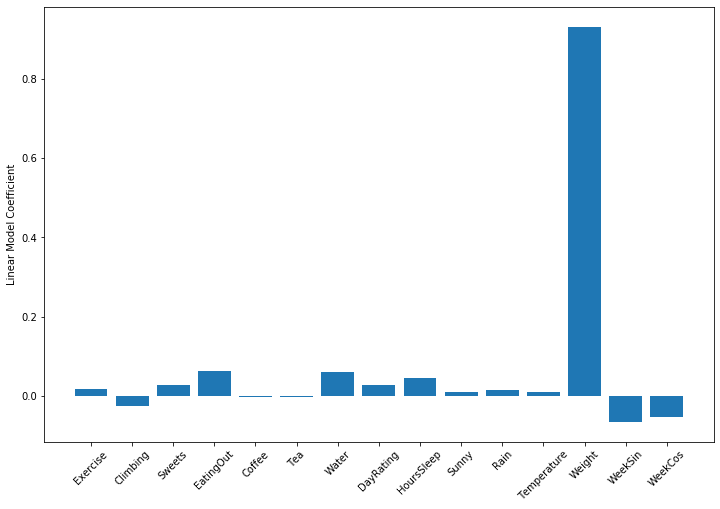

In [12]:
plot_linear_model_coeffs(model_lin, X_train, df)

Let's load the best FCNN/CNN/RNN models and see how their mean absolute error (MAE) compares to the linear and baseline models. 

In [13]:
fcnn_model = tf.keras.models.load_model(FILEPATH_FCNN)
cnn_model = tf.keras.models.load_model(FILEPATH_CNN)
rnn_model = tf.keras.models.load_model(FILEPATH_RNN)

n_timesteps_cnn = cnn_model.input_shape[1]
n_timesteps_rnn = rnn_model.input_shape[1]

X_train_cnn, y_train_cnn, _, _, X_test_cnn, y_test_cnn, nan_idxs_cnn = rescale_window_split_dataframe(df, 
                                                                                                n_timesteps=n_timesteps_cnn)
X_train_rnn, y_train_rnn, _, _, X_test_rnn, y_test_rnn, nan_idxs_rnn = rescale_window_split_dataframe(df, 
                                                                                                n_timesteps=n_timesteps_rnn)

y_fcnn = fcnn_model.predict(X_test)[:, 0, 0]
y_cnn = cnn_model.predict(X_test_cnn)[:, n_timesteps_cnn-1, 0]
y_rnn = rnn_model.predict(X_test_rnn)[:, n_timesteps_rnn-1, 0]

score_dict["FCNN MAE"]  = mean_absolute_error(y_fcnn, y_test)
score_dict["CNN MAE"]  = mean_absolute_error(y_cnn, y_test_cnn[:, n_timesteps_cnn-1])
score_dict["RNN MAE"]  = mean_absolute_error(y_rnn, y_test_rnn[:, n_timesteps_rnn-1])

score_dict

{'Baseline MAE': 0.23625262730251118,
 'Linear MAE': 0.24475079642184006,
 'FCNN MAE': 0.2485452444382229,
 'CNN MAE': 0.24648703509621842,
 'RNN MAE': 0.24826733067026335}

It looks like none of the models outperform the baseline model, but that the simple linear model does better than the neural networks. Plotting the various models against the test data (below) shows that they tended to learn broadly similar functions, with the FCNN being the "spikiest". It would seem that incorporating previous days' values, as the CNN/RNN do, doesn't help their performance. I have also only plotted the data values up until day 712 for visualization purposes, because at the end of the year their were many missing data values. The RNN and CNN predictions also don't start at the beginning of the data set due to the fact that they use multiple time steps in their predictions, 4 and 3 respectively, and so they need at least that many time steps to pass before making a prediction.

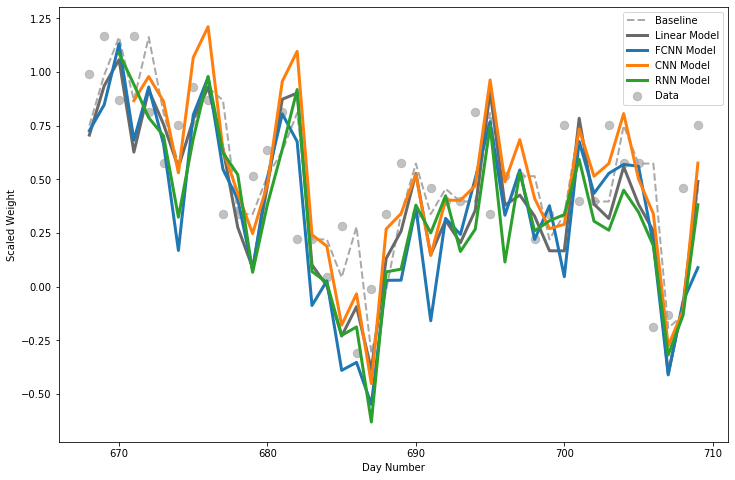

In [14]:
day_number = np.arange(len(df) - len(X_test), len(df))
plot_predictions(day_number, X_test, y_test[:,0], y_lin, y_fcnn, y_cnn, y_rnn, nan_idxs_test, nan_idxs_cnn, nan_idxs_rnn, 
                 n_timesteps_cnn, n_timesteps_rnn, PLOT_BOUNDS)

### Reduced Feature Set

Let's run the same analysis on the reduced feature dataset. Again I fit a linear model for comparison and we see that the feature weighting is similar

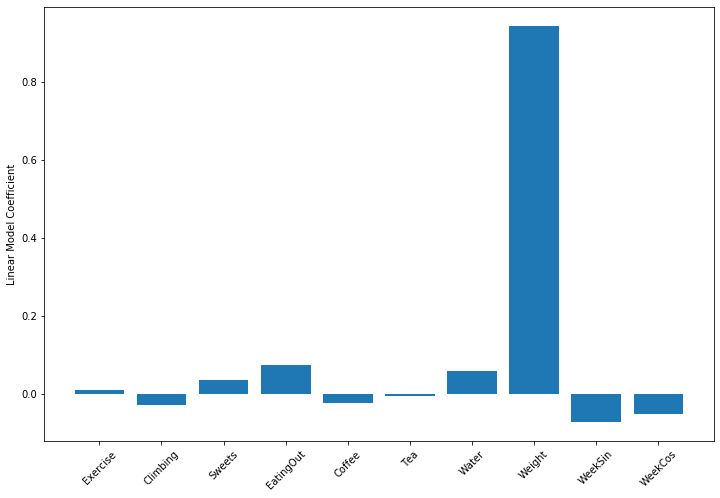

In [15]:
X_train, y_train, _, _, X_test, y_test, nan_idxs_test = rescale_window_split_dataframe(df_reduced)

# Linear model df_reduced
model_lin = LinearRegression().fit(np.squeeze(X_train), np.squeeze(y_train))
y_lin = model_lin.predict(np.squeeze(X_test))

score_dict["Linear MAE"] = mean_absolute_error(y_lin, y_test)
plot_linear_model_coeffs(model_lin, X_train, df_reduced)

If we compare the MAEs of the different models thouogh we now see a different pattern emerge, with the CNN & RNN outperforming the other models and the baseline. All models improve their performance and beat the baseline with fewer features except for the FCNN, which imrpves but doesn't manage to beat the baseline. This suggests that some of the features in the full dataset are mostly noise with little useful information. Also information from the previous days may be helping the RNN and CNN outperform the other models on the reduced dataset.

In [17]:
# Load reduced models
fcnn_model = tf.keras.models.load_model(FILEPATH_FCNN_REDUCED)
cnn_model = tf.keras.models.load_model(FILEPATH_CNN_REDUCED)
rnn_model = tf.keras.models.load_model(FILEPATH_RNN_REDUCED)

n_timesteps_cnn = cnn_model.input_shape[1]
n_timesteps_rnn = rnn_model.input_shape[1]

X_train_cnn, y_train_cnn, _, _, X_test_cnn, y_test_cnn, nan_idxs_cnn = rescale_window_split_dataframe(df_reduced, 
                                                                                                n_timesteps=n_timesteps_cnn)
X_train_rnn, y_train_rnn, _, _, X_test_rnn, y_test_rnn, nan_idxs_rnn = rescale_window_split_dataframe(df_reduced, 
                                                                                                n_timesteps=n_timesteps_rnn)

y_fcnn = fcnn_model.predict(X_test)[:, 0, 0]
y_cnn = cnn_model.predict(X_test_cnn)[:, n_timesteps_cnn-1, 0]
y_rnn = rnn_model.predict(X_test_rnn)[:, n_timesteps_rnn-1, 0]

score_dict["FCNN MAE"]  = mean_absolute_error(y_fcnn, y_test)
score_dict["CNN MAE"]  = mean_absolute_error(y_cnn, y_test_cnn[:, n_timesteps_cnn-1])
score_dict["RNN MAE"]  = mean_absolute_error(y_rnn, y_test_rnn[:, n_timesteps_rnn-1])

score_dict

{'Baseline MAE': 0.23625262730251118,
 'Linear MAE': 0.2320823065563961,
 'FCNN MAE': 0.24505545712940768,
 'CNN MAE': 0.22902692459711674,
 'RNN MAE': 0.22877776866895738}

Looking again at the various model predictions we can see that the RNN and CNN performance improved especially at the minimum right before day 690, not overshooting as much as they previously did.

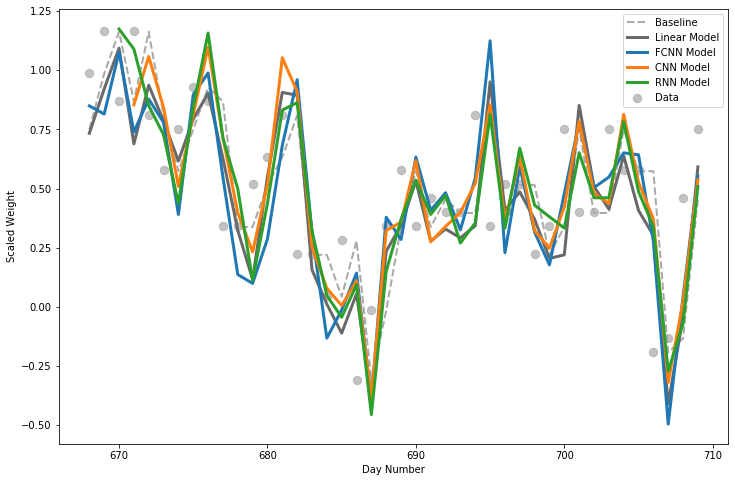

In [18]:
plot_predictions(day_number, X_test, y_test[:,0], y_lin, y_fcnn, y_cnn, y_rnn, nan_idxs_test, nan_idxs_cnn, nan_idxs_rnn, 
                 n_timesteps_cnn, n_timesteps_rnn, PLOT_BOUNDS)

### Conclusions

My hope at the beginning of the project was to be able to predict weight changes with a coarse, easy to record set of variables like number of times eating out, minutes of exercise, and so on. This hopes was partially fulfilled - the models built on the reduced feature set were better at predicting weight changes than the baseline, but only marginally so. To be more accurate one would probably have to resort to a more involved data collection process, such as calorie counting. 